<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Customise/SubclassCustom/Subclassing_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

#### Create a simple model using the model subclassing API

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Build the model
class MyModel(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = tf.keras.layers.Dense(units=64,
            activation=tf.keras.activations.relu)
        self.dense_2 = tf.keras.layers.Dense(units=10,
            activation=tf.keras.activations.relu)
        self.dense_3 = tf.keras.layers.Dense(units=num_classes,
            activation=tf.keras.activations.softmax)
        self.dropout = tf.keras.layers.Dropout(rate=0.4)

    def call(self, inputs, training=True):
        x1 = self.dense_1(inputs=inputs)
        x2 = self.dense_2(inputs=inputs)
        concat = tf.keras.layers.Concatenate()([x1, x2])
        concat = self.dropout(inputs=concat, training=training)
        return self.dense_3(inputs=concat)

# Print the model summary
my_model = MyModel(num_classes=5, name="my_model")
my_model(inputs=tf.random.normal(shape=(1, 10)))
my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  704       
                                                                 
 dense_1 (Dense)             multiple                  110       
                                                                 
 dense_2 (Dense)             multiple                  375       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 1189 (4.64 KB)
Trainable params: 1189 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

#### Create custom layers

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Create a custom layer to accumulate means of output values
class MyLayerMean(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        # Specify trainable weights
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros())
        self.sum_activation = tf.Variable(
            initial_value=tf.zeros(shape=(units,)),
            trainable=False)
        self.number_call = tf.Variable(initial_value=0,
            trainable=False)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.RandomNormal())

    def call(self, inputs):
        activations = tf.linalg.matmul(a=inputs, b=self.w) + self.b
        self.sum_activation.assign_add(delta=tf.math.reduce_sum(
            input_tensor=activations, axis=0))
        self.number_call.assign_add(delta=inputs.shape[0])
        return activations, self.sum_activation / tf.cast(
                x=self.number_call, dtype=tf.float32)

dense_layer = MyLayerMean(units=3)

# Test the layer
x = tf.ones(shape=(2, 5))
y, activation_means = dense_layer(inputs=x)
print("trainable weights:", len(dense_layer.trainable_weights))
print("non-trainable weights:", len(dense_layer.non_trainable_weights))
print(f"activation_means: {activation_means.numpy()}")
print(f"weights: {dense_layer.weights}")

trainable weights: 2
non-trainable weights: 2
activation_means: [ 0.01885552 -0.07703885 -0.2915517 ]
weights: [<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, <tf.Variable 'my_layer_mean/Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.02358919, -0.01442928, -0.0221293 ],
       [ 0.06809177, -0.09231842, -0.06502789],
       [ 0.01064425,  0.0060349 , -0.04163619],
       [-0.0387267 ,  0.03659106, -0.10442163],
       [ 0.00243539, -0.01291711, -0.05833671]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.03771103, -0.1540777 , -0.5831034 ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2>]


#### Implement the custom layers into a model

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Build the model using custom layers with the model subclassing API
class MyModel(tf.keras.Model):
    def __init__(self, units_1, units_2, units_3, **kwargs):
        super().__init__(**kwargs)
        # Define layers
        self.layer_1 = MyLayer(units=units_1)
        self.layer_2 = MyLayer(units=units_2)
        self.layer_3 = MyLayer(units=units_3)
        self.dropout = MyDropout(rate=0.5)

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs=inputs)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_2(inputs=x)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_3(inputs=x)
        return tf.nn.softmax(logits=x)

# Create a custom layer
class MyLayer(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
      super().__init__(**kwargs)
      self.units = units
      self.b = self.add_weight(shape=(units,),
          initializer=tf.keras.initializers.Zeros())

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
          initializer=tf.keras.initializers.RandomNormal())

  def call(self, inputs):
      return tf.linalg.matmul(a=inputs, b=self.w) + self.b

# Create a Dropout layer as a custom layer
class MyDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(x=inputs, rate=self.rate)

# Instantiate a model object
my_model = MyModel(units_1=64, units_2=64, units_3=46, name="my_model")
print(my_model(inputs=tf.random.normal(shape=(1, 10000))))
my_model.summary()

tf.Tensor(
[[0.03964711 0.01326958 0.02763753 0.01076229 0.00946367 0.03262109
  0.01824417 0.00908988 0.06717901 0.06570987 0.01522713 0.01349179
  0.02473041 0.01732281 0.01864108 0.03071251 0.01356731 0.01164669
  0.03300926 0.00993308 0.01679034 0.01374915 0.06827164 0.02038475
  0.00887607 0.01661218 0.01125773 0.01611739 0.02482517 0.01127254
  0.00647558 0.01062837 0.01034763 0.00456736 0.05896316 0.00457546
  0.00695589 0.01401417 0.02193612 0.03387661 0.02122178 0.0189374
  0.02321725 0.03404637 0.02700517 0.01316846]], shape=(1, 46), dtype=float32)
Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer (MyLayer)          multiple                  640064    
                                                                 
 my_layer_1 (MyLayer)        multiple                  4160      
                                                                 
 my_layer_2 (MyLayer)

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

x = tf.constant(value=[0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(tensor=x)
    y = tf.math.reduce_sum(input_tensor=x**2)
    z = tf.math.sin(x=y)
    dz_dy, dz_dx = tape.gradient(target=z, sources=[y, x])

print(f"dz_dy: {dz_dy}")
print(f"dz_dx: {dz_dx}")

dz_dy: 0.13673722743988037
dz_dx: [0.         0.27347445 0.5469489  0.82042336]


#### Create synthetic data

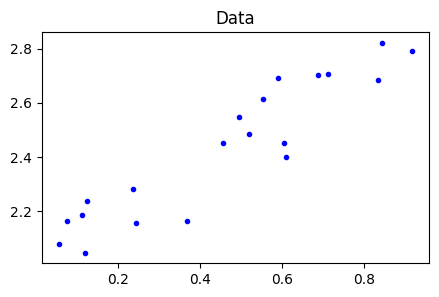

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
%matplotlib inline
import matplotlib.pyplot as plt

# Create data from a noise contaminated linear model
@tf.function
def MakeNoisyData(w, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = w * x + b + noise
    return x, y

w, b = 1, 2
x_train, y_train = MakeNoisyData(w=w, b=b)

plt.figure(figsize=(5, 3))
plt.title(label="Data")
plt.plot(x_train, y_train, 'b.')
plt.show()

#### Build, train and plot the linear regression model

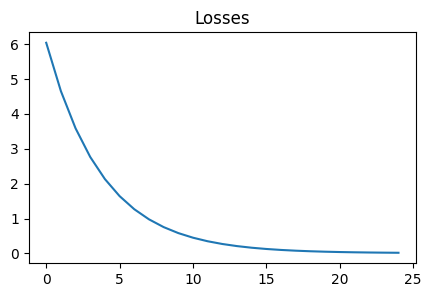

w:1,  trained w:[0.8987737]
b:2,  trained b:[1.9256457]


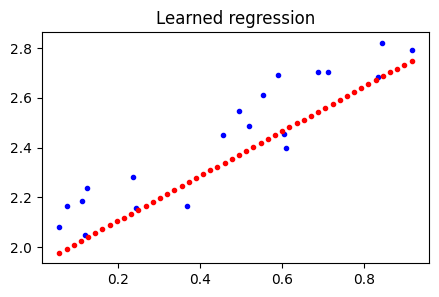

In [ ]:
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
%matplotlib inline
import matplotlib.pyplot as plt

# Build a custom layer for the linear regression model
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.w = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.RandomNormal())
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros())

    def call(self, inputs):
        return self.w*inputs + self.b

linear_regression = LinearLayer(units=1)

# Define the mean squared error loss function & gradients
@tf.function
def get_loss_and_grads(x, y):
    with tf.GradientTape() as tape:
        y_pred = linear_regression(inputs=x_train)
        loss = tf.math.reduce_mean(
            input_tensor=tf.math.square(x=(y_pred-y)))
        grads = tape.gradient(target=loss,
            sources=linear_regression.trainable_variables)
    return loss, grads

# Implement a gradient descent training loop for the linear regression model
lr = 0.05
steps = 25

losses = []
for i in range(steps):
    loss, grad = get_loss_and_grad(x=x_train, y=y_train)
    losses.append(loss.numpy())
    linear_regression.w.assign_sub(delta=lr*grad[0])
    linear_regression.b.assign_sub(delta=lr*grad[1])

plt.figure(figsize=(5, 3))
plt.title(label="Losses")
plt.plot(losses)
plt.show()

# Plot the learned regression model
print("w:{},  trained w:{}".format(w, linear_regression.w.numpy()))
print("b:{},  trained b:{}".format(b, linear_regression.b.numpy()))

plt.figure(figsize=(5, 3))
plt.title(label="Learned regression")
plt.plot(x_train, y_train, 'b.')
x_linear_regression = np.linspace(start=min(x_train),
    stop=max(x_train), num=50)
y_linear_regression = linear_regression.w * x_linear_regression \
    + linear_regression.b
plt.plot(x_linear_regression, y_linear_regression, 'r.')
plt.show()

***
<a id="coding_tutorial_4"></a>
## Custom training loops

#### Load the reuters dataset and define the class_names

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Load the dataset
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.reuters.load_data(num_words=10000)

class_names = [
    'cocoa', 'grain', 'veg-oil', 'earn', 'acq', 'wheat', 'copper', 'housing',
    'money-supply', 'coffee', 'sugar', 'trade', 'reserves', 'ship', 'cotton',
    'carcass', 'crude', 'nat-gas', 'cpi', 'money-fx', 'interest', 'gnp',
    'meal-feed', 'alum', 'oilseed', 'gold', 'tin', 'strategic-metal',
    'livestock', 'retail', 'ipi', 'iron-steel', 'rubber', 'heat', 'jobs',
    'lei', 'bop', 'zinc', 'orange', 'pet-chem', 'dlr', 'gas', 'silver',
    'wpi', 'hog', 'lead'
]

# Print the class of the first sample
print("Label: {}".format(class_names[train_labels[0]]))

print("Shape of train labels:", train_labels.shape)

2110848/2110848 [==============================] - 0s 0us/step
Label: earn
Shape of train labels: (8982,)


#### Get the dataset word index

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Load the Reuters word index
word_to_index = tf.keras.datasets.reuters.get_word_index()
invert_word_index = dict([(value, key)
    for (key, value) in word_to_index.items()])

# Print the first data example sentence
text_news = ' '.join([invert_word_index.get(i - 3, '?')
    for i in train_data[0]])
print(text_news)

550378/550378 [==============================] - 0s 0us/step
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [ ]:
import numpy as np

# Define a function that encodes the data into a 'bag of words' representation
def bag_of_words(text_samples, elements=10000):
    output = np.zeros(shape=(len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(text_samples=train_data)
x_test = bag_of_words(text_samples=test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Build the model

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Define the custom layers and model
class MyModel(tf.keras.Model):
    def __init__(self, units_1, units_2, units_3, **kwargs):
        super().__init__(**kwargs)
        # Define layers
        self.layer_1 = MyLayer(units=units_1)
        self.layer_2 = MyLayer(units=units_2)
        self.layer_3 = MyLayer(units=units_3)
        self.dropout = MyDropout(rate=0.5)

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs=inputs)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_2(inputs=x)
        x = tf.nn.relu(features=x)
        x = self.dropout(inputs=x)
        x = self.layer_3(inputs=x)
        return tf.nn.softmax(logits=x)

class MyLayer(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros(),
            name="bias")

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.RandomNormal(),
            name="kernel")

    def call(self, inputs):
        return tf.linalg.matmul(a=inputs, b=self.w) + self.b

class MyDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs):
        # Define forwared pass for dropout layer
        return tf.nn.dropout(x=inputs, rate=self.rate)

# Instantiate the model object
model = MyModel(units_1=64, units_2=64, units_3=46)
print(model(inputs=tf.random.normal(shape=(1, 10000))))
model.summary()

tf.Tensor(
[[0.03964711 0.01326958 0.02763753 0.01076229 0.00946367 0.03262109
  0.01824417 0.00908988 0.06717901 0.06570987 0.01522713 0.01349179
  0.02473041 0.01732281 0.01864108 0.03071251 0.01356731 0.01164669
  0.03300926 0.00993308 0.01679034 0.01374915 0.06827164 0.02038475
  0.00887607 0.01661218 0.01125773 0.01611739 0.02482517 0.01127254
  0.00647558 0.01062837 0.01034763 0.00456736 0.05896316 0.00457546
  0.00695589 0.01401417 0.02193612 0.03387661 0.02122178 0.0189374
  0.02321725 0.03404637 0.02700517 0.01316846]], shape=(1, 46), dtype=float32)
Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer_3 (MyLayer)        multiple                  640064    
                                                                 
 my_layer_4 (MyLayer)        multiple                  4160      
                                                                 
 my_layer_5 (MyLaye

#### Define the loss function and optimizer



In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Define the categorical cross entropy loss
loss_crossentropy = tf.keras.losses.SparseCategoricalCrossentropy()

# Use the @tf.function decorator
@tf.function
def get_loss_wd(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
             kernel_variables.append(w)
    wd_penalty = wd * tf.math.reduce_sum([tf.math.reduce_sum(
        tf.math.square(x=k)) for k in kernel_variables])
    pred = model(inputs=x)
    return loss_crossentropy(y_true=y, y_pred=pred) + wd_penalty

# Define a function to compute the forward and backward pass
@tf.function
def get_loss_grads(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss = get_loss_wd(model=model, x=inputs,
            y=targets, wd=wd)
        grads = tape.gradient(target=loss,
            sources=model.trainable_variables)
    return loss, grads

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

#### Print the autograph code

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Use tf.autograph.to_code to see the generated code
print(tf.autograph.to_code(entity=get_loss_grads.python_function))

def tf__get_loss_grads(model, inputs, targets, wd):
    with ag__.FunctionScope('get_loss_grads', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss = ag__.converted_call(ag__.ld(get_loss_wd), (), dict(model=ag__.ld(model), x=ag__.ld(inputs), y=ag__.ld(targets), wd=ag__.ld(wd)), fscope)
            grads = ag__.converted_call(ag__.ld(tape).gradient, (), dict(target=ag__.ld(loss), sources=ag__.ld(model).trainable_variables), fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss), ag__.ld(grads))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



#### Train the model

Epoch 000: Train loss: 3.312, Train accuracy: 48.185%
           Test loss: 2.987, Test accuracy: 50.071%
Epoch 001: Train loss: 2.516, Train accuracy: 54.824%
           Test loss: 2.421, Test accuracy: 55.691%
Epoch 002: Train loss: 2.252, Train accuracy: 58.607%
           Test loss: 2.201, Test accuracy: 59.090%
Epoch 003: Train loss: 2.114, Train accuracy: 60.920%
           Test loss: 2.080, Test accuracy: 61.209%
Epoch 004: Train loss: 2.027, Train accuracy: 62.449%
           Test loss: 2.002, Test accuracy: 62.599%
Epoch 005: Train loss: 1.965, Train accuracy: 63.482%
           Test loss: 1.946, Test accuracy: 63.625%
Epoch 006: Train loss: 1.921, Train accuracy: 64.274%
           Test loss: 1.905, Test accuracy: 64.351%
Epoch 007: Train loss: 1.886, Train accuracy: 64.896%
           Test loss: 1.873, Test accuracy: 64.968%
Epoch 008: Train loss: 1.857, Train accuracy: 65.419%
           Test loss: 1.846, Test accuracy: 65.465%
Epoch 009: Train loss: 1.835, Train accuracy: 

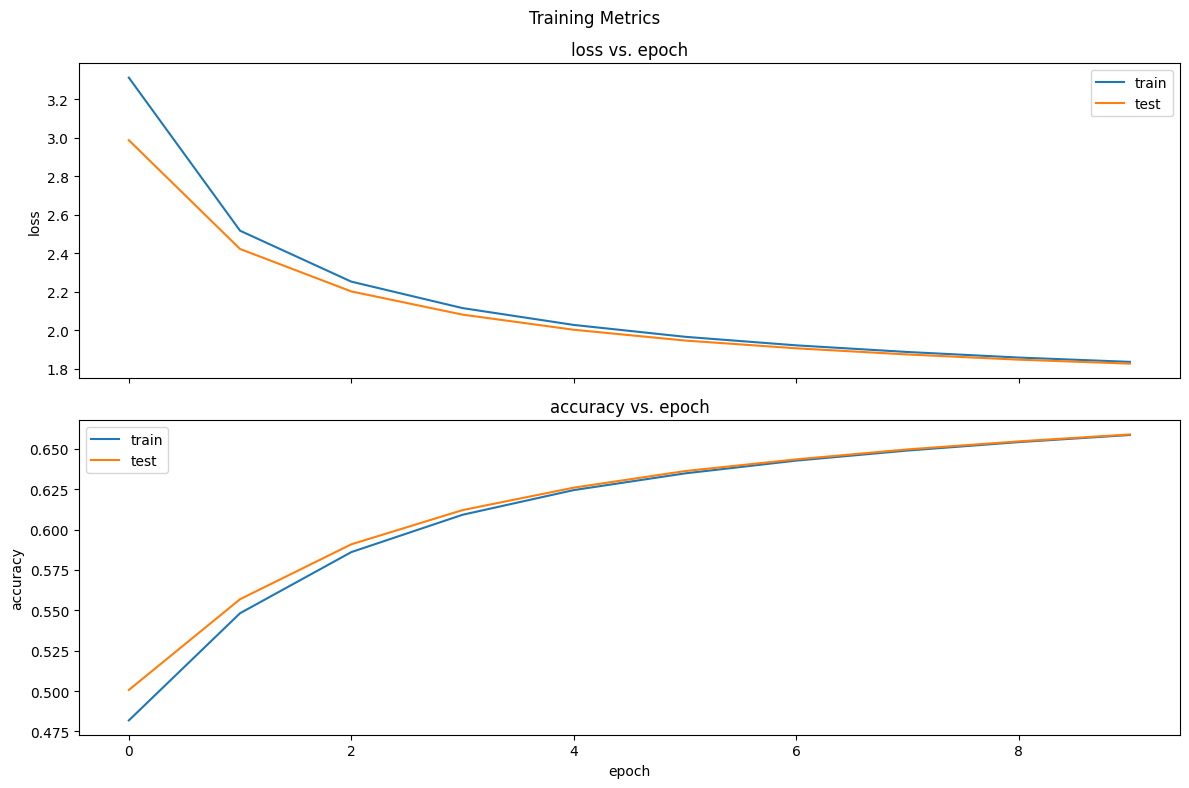

Prediction from the model
Predict: earn
  Label: earn


In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Implement the training loop
start_time = time.time()

# Create a Dataset object for the train set
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(x_train, train_labels))
train_dataset = train_dataset.batch(batch_size=32)

# Create a Dataset object for the test set
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(x_test, test_labels))
test_dataset = test_dataset.batch(batch_size=32)

# Define the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Collect average loss and accuracy
metric_avg = tf.keras.metrics.Mean()
metric_acc = tf.keras.metrics.CategoricalAccuracy()

# Keep results for plotting
history = {
    "train_loss": [], "train_accuracy": [],
    "test_loss": [], "test_accuracy": []
}
train_loss_results, test_loss_results = [], []
train_accuracy_results, test_accuracy_results = [], []
num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    # Training loop
    for x, y in train_dataset:
        pred = model(inputs=x)
        # Compute current loss
        loss, grads = get_loss_grads(model=model, inputs=x,
            targets=y, wd=weight_decay)
        # Optimize the model
        optimizer.apply_gradients(grads_and_vars=\
            zip(grads, model.trainable_variables))
        avg_metric(values=loss)
        # Compare predicted label to actual label
        acc_metric(y_true=tf.keras.utils.to_categorical(y=y, num_classes=46),
            y_pred=pred)

    avg_metric_result = avg_metric.result().numpy()
    acc_metric_result = acc_metric.result().numpy()
    print("Epoch {:03d}: Train loss: {:.3f}, Train accuracy: {:.3%}"\
        .format(epoch, avg_metric_result, acc_metric_result))
    train_loss_results.append(avg_metric_result)
    train_accuracy_results.append(acc_metric_result)

    # Evaluate the model
    # Loop over the test set and print scores
    for x, y in test_dataset:
        pred = model(inputs=x)
        # Compute current loss
        loss = loss_crossentropy(y_true=y, y_pred=pred)
        avg_metric(values=loss)
        # Compare predicted label to actual label
        acc_metric(y_true=tf.keras.utils.to_categorical(y=y, num_classes=46),
            y_pred=pred)

    avg_metric_result = avg_metric.result().numpy()
    acc_metric_result = acc_metric.result().numpy()
    print("           Test loss: {:.3f}, Test accuracy: {:.3%}"\
        .format(avg_metric_result, acc_metric_result))
    test_loss_results.append(avg_metric_result)
    test_accuracy_results.append(acc_metric_result)

# End epoch
print("Duration :{:.3f}".format(time.time() - start_time))

df_history = pd.DataFrame({
    "epoch": np.arange(num_epochs),
    "train_loss": np.array(train_loss_results),
    "test_loss": np.array(test_loss_results),
    "train_accuracy": np.array(train_accuracy_results),
    "test_accuracy": np.array(test_accuracy_results)
})

# Plot the learning curves
# Plot the training loss and accuracy
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
axes[1].set_xlabel(xlabel="epoch")
for ax, metric in zip(axes, ["loss", "accuracy"]):
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{metric}")
    sns.lineplot(ax=ax, label="test", data=df_history,
        x="epoch", y=f"test_{metric}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{metric}")
    ax.set_title(label=f"{metric} vs. epoch")
fig.tight_layout()
plt.show()

# # Get the model prediction for an example input
predicted_label = np.argmax(model(
    inputs=x_train[np.newaxis, 0]), axis=1)[0]
print("Prediction from the model")
print("Predict: {}".format(class_names[predicted_label]))
print("  Label: {}".format(class_names[train_labels[0]]))